In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import plotly.express as ex
import plotly.offline as pyo
import plotly.graph_objects as go

import scipy.stats
from imblearn.pipeline import Pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2, RFE, RFECV, SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, roc_curve, roc_auc_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.under_sampling import NearMiss, TomekLinks

In [4]:
df = pd.read_csv('bank-full.csv',';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.drop(columns='day month poutcome'.split(), inplace=True)

In [6]:
df['y'] = np.where(df['y']=='no', 0, 1)

In [7]:
X = df.drop(columns='y')
y = df.y

In [16]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y ,stratify=y, random_state=8, test_size=.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val ,stratify=y_train_val, random_state=8, test_size=.25)

In [17]:
education_mapping=[
    {'col': 0,
     'mapping': {'primary': 1, 'secondary': 2, 'tertiary': 3}}
]

### __Random Forest__

In [18]:
# Untuk impute dan onehot JOB
mode_onehot_pipeline = Pipeline([
    ('mode_impute_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_onehot', OneHotEncoder(drop='first'))
])

# Untuk impute dan ordinal EDUCATION
mode_ordinal_pipeline = Pipeline([
    ('mode_ordinal_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_ordinal', ce.OrdinalEncoder(cols=['education'], mapping=education_mapping))
])

# Untuk impute dan onehot CONTACT
constant_onehot_pipeline = Pipeline([
    ('constant_impute_cat', SimpleImputer(missing_values='unknown', strategy='constant', fill_value='never')),
    ('constant_onehot', OneHotEncoder(drop='first'))
])

# Untuk onehot MARITAL, DEFAULT, HOUSING, LOAN
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

# Untuk scaling dan polynomial AGE, CAMPAIGN, PDAYS, PREVIOUS
# numerical_pipeline = Pipeline([
#     ('minmax_scaler', MinMaxScaler())
#     ('poly', PolynomialFeatures(3, include_bias=False))
# ])

transformer_fe = ColumnTransformer([
    ('mode_onehot_pipe', mode_onehot_pipeline, ['job']),
    ('mode_ordinal_pipe', mode_ordinal_pipeline, ['education']),
    ('constant_onehot_pipe', constant_onehot_pipeline, ['contact']),
    ('onehot_pipe', onehot_pipeline, ['marital', 'default', 'housing', 'loan'])
#     ('numerical_pipe', numerical_pipeline, ['age','campaign','pdays','previous'])
], remainder='passthrough')

# model initializing
rfc_rfe = RandomForestClassifier(random_state=8)
smote = SMOTE(random_state=8)
rfe = RFE(rfc_rfe, n_features_to_select = 10, step=1)
rfc_clf = RandomForestClassifier(random_state=8)

rfc_pipeline = Pipeline([
    ('transformer', transformer_fe),
    ('resample', smote),
    ('selection', rfe),
    ('clf', rfc_clf)
])

In [19]:
model_default_rfc = rfc_pipeline.fit(X_train, y_train)
y_pred_default_rfc = model_default_rfc.predict(X_val)

D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [20]:
print(classification_report(y_val, y_pred_default_rfc))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      7984
           1       0.52      0.39      0.44      1058

    accuracy                           0.89      9042
   macro avg       0.72      0.67      0.69      9042
weighted avg       0.87      0.89      0.88      9042



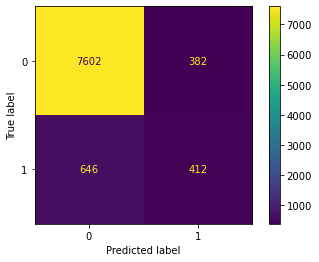

In [21]:
plot_confusion_matrix(rfc_pipeline,
                     X_val,
                     y_val)

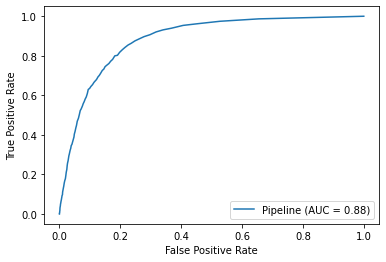

In [22]:
plot_roc_curve(model_default_rfc, X_val, y_val)

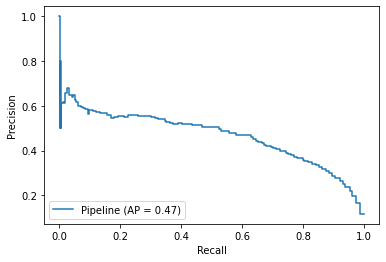

In [23]:
plot_precision_recall_curve(model_default_rfc, X_val, y_val)

In [65]:
rfc_default_cv = cross_val_score(rfc_pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='recall')

In [72]:
rfc_default_cv

array([0.40314961, 0.41167192, 0.40536278, 0.41732283, 0.39527559])

In [93]:
hyperparam_space_rfc = {
    'clf__max_depth': [2,3,4,5,6,7],
    'clf__min_samples_split': [4,5,6,7,8,9,10],
    'clf__max_features': [7,8,9,10,11],
    'clf__criterion': ['entropy', 'gini']
}

skf = StratifiedKFold(n_splits=5)

grid_search_rfc = GridSearchCV(rfc_pipeline, hyperparam_space_rfc, scoring='recall', n_jobs=-1, cv=skf, verbose=2)

In [ ]:
grid_search_rfc.fit(X_train, y_train)

In [ ]:
print('best score', grid_search_rfc.best_score_)
print('best params', grid_search_rfc.best_params_)

In [ ]:
cv_result_rfc = pd.DataFrame(grid_search_rfc.cv_results_)
cv_result_rfc.head()

In [ ]:
cv_result_rfc[cv_result_rfc['rank_test_score']==1]

### __KNN__

#### __A. Pipeline__

In [25]:
# Untuk impute dan onehot JOB
mode_onehot_pipeline = Pipeline([
    ('mode_impute_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_onehot', OneHotEncoder(drop='first'))
])

# Untuk impute dan ordinal EDUCATION
mode_ordinal_pipeline = Pipeline([
    ('mode_ordinal_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_ordinal', ce.OrdinalEncoder(cols=['education'], mapping=education_mapping))
])

# Untuk impute dan onehot CONTACT
constant_onehot_pipeline = Pipeline([
    ('constant_impute_cat', SimpleImputer(missing_values='unknown', strategy='constant', fill_value='never')),
    ('constant_onehot', OneHotEncoder(drop='first'))
])

# Untuk onehot MARITAL, DEFAULT, HOUSING, LOAN
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

# Untuk scaling dan polynomial AGE, CAMPAIGN, PDAYS, PREVIOUS
numerical_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
#     ('poly', PolynomialFeatures(3, include_bias=False))
])

transformer_fe = ColumnTransformer([
    ('mode_onehot_pipe', mode_onehot_pipeline, ['job']),
    ('mode_ordinal_pipe', mode_ordinal_pipeline, ['education']),
    ('constant_onehot_pipe', constant_onehot_pipeline, ['contact']),
    ('onehot_pipe', onehot_pipeline, ['marital', 'default', 'housing', 'loan']),
    ('numerical_pipe', numerical_pipeline, ['age','campaign','pdays','previous'])
], remainder='passthrough')

# model initializing
rfc = RandomForestClassifier(random_state=8)
smote = SMOTE(random_state=8)
rfe = RFE(rfc, n_features_to_select = 10, step=1)
knn = KNeighborsClassifier(n_neighbors=5)

knn_pipeline = Pipeline([
    ('transformer', transformer_fe),
    ('resample', smote),
    ('selection', rfe),
    ('clf', knn)
])

#### __B. Train and Predict Benchmark Model__

In [26]:
model_default_knn = knn_pipeline.fit(X_train, y_train)
y_pred_default_knn = model_default_knn.predict(X_val)

D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



#### __C. Evaluation of Benchmark Model__

In [27]:
print(classification_report(y_val, y_pred_default_knn))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83      7984
           1       0.24      0.60      0.34      1058

    accuracy                           0.73      9042
   macro avg       0.59      0.68      0.59      9042
weighted avg       0.85      0.73      0.77      9042



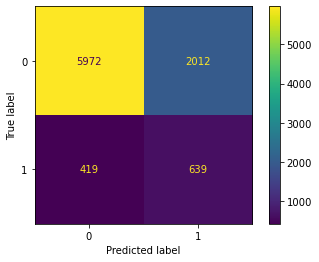

In [28]:
plot_confusion_matrix(knn_pipeline,
                     X_val,
                     y_val)

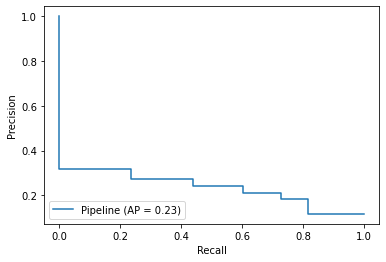

In [30]:
plot_precision_recall_curve(model_default_knn, X_val, y_val)

In [64]:
knn_default_cv = cross_val_score(knn_pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='recall')

In [170]:
print('KNN Benchmark Model Recall Score: ', knn_default_cv.mean())

KNN Benchmark Model Recall Score:  0.5773725129784644


#### __D. Hyperparameter Tuning__

In [95]:
param_grid_knn = {'clf__n_neighbors':[5,6,7,8,9,10],
          'clf__leaf_size':[1,2,3,5],
          'clf__weights':['uniform', 'distance'],
          'clf__algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'clf__n_jobs':[-1]}

In [96]:
grid_search_knn = GridSearchCV(
    knn_pipeline,
    param_grid = param_grid_knn,
    cv = 5,
    scoring='recall',
    n_jobs=-1,
    verbose = 1
)

In [97]:
grid_search_knn.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 88.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 206.4min
[Parallel(n_jobs=-1)]: Done 832 tasks      | elapsed: 399.8min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 468.5min finished
D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('mode_onehot_pipe',
                                                                         Pipeline(steps=[('mode_impute_cat',
                                                                                          SimpleImputer(missing_values='unknown',
                                                                                                        strategy='most_frequent')),
                                                                                         ('mode_onehot',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['job']),
                                                                     

#### __E. Hyperparameter Tuning Evaluation__

In [98]:
cv_result_knn = pd.DataFrame(grid_search_knn.cv_results_)
cv_result_knn.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__algorithm,param_clf__leaf_size,param_clf__n_jobs,param_clf__n_neighbors,param_clf__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,290.525285,3.433923,1.162675,0.076889,auto,1,-1,5,uniform,"{'clf__algorithm': 'auto', 'clf__leaf_size': 1...",0.559055,0.566246,0.591483,0.577953,0.592126,0.577373,0.013240,92
1,269.168642,24.587261,0.482025,0.078194,auto,1,-1,5,distance,"{'clf__algorithm': 'auto', 'clf__leaf_size': 1...",0.503937,0.545741,0.559937,0.551181,0.570079,0.546175,0.022672,161
2,238.741456,2.682823,1.189514,0.178620,auto,1,-1,6,uniform,"{'clf__algorithm': 'auto', 'clf__leaf_size': 1...",0.502362,0.528391,0.533123,0.525984,0.543307,0.526634,0.013511,177
3,228.617960,4.171436,0.365189,0.065925,auto,1,-1,6,distance,"{'clf__algorithm': 'auto', 'clf__leaf_size': 1...",0.513386,0.556782,0.559937,0.551181,0.582677,0.552793,0.022430,145
4,229.487358,7.362905,1.180183,0.338150,auto,1,-1,7,uniform,"{'clf__algorithm': 'auto', 'clf__leaf_size': 1...",0.598425,0.600946,0.618297,0.617323,0.611024,0.609203,0.008201,17


In [138]:
cv_result_knn['n_neighbors'] = list(map(lambda x: x['clf__n_neighbors'], cv_result_knn.params.values))
cv_result_knn['leaf_size'] = list(map(lambda x: x['clf__leaf_size'], cv_result_knn.params.values))
cv_result_knn['weights'] = list(map(lambda x: x['clf__weights'], cv_result_knn.params.values))
cv_result_knn['algorithm'] = list(map(lambda x: x['clf__algorithm'], cv_result_knn.params.values))
cv_result_knn.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__algorithm,param_clf__leaf_size,param_clf__n_jobs,param_clf__n_neighbors,param_clf__weights,params,...,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,n_neighors,leaf_size,weights,algorithm,n_neighbors
0,290.525285,3.433923,1.162675,0.076889,auto,1,-1,5,uniform,"{'clf__algorithm': 'auto', 'clf__leaf_size': 1...",...,0.577953,0.592126,0.577373,0.013240,92,5,1,uniform,auto,5
1,269.168642,24.587261,0.482025,0.078194,auto,1,-1,5,distance,"{'clf__algorithm': 'auto', 'clf__leaf_size': 1...",...,0.551181,0.570079,0.546175,0.022672,161,5,1,distance,auto,5
2,238.741456,2.682823,1.189514,0.178620,auto,1,-1,6,uniform,"{'clf__algorithm': 'auto', 'clf__leaf_size': 1...",...,0.525984,0.543307,0.526634,0.013511,177,6,1,uniform,auto,6
3,228.617960,4.171436,0.365189,0.065925,auto,1,-1,6,distance,"{'clf__algorithm': 'auto', 'clf__leaf_size': 1...",...,0.551181,0.582677,0.552793,0.022430,145,6,1,distance,auto,6
4,229.487358,7.362905,1.180183,0.338150,auto,1,-1,7,uniform,"{'clf__algorithm': 'auto', 'clf__leaf_size': 1...",...,0.617323,0.611024,0.609203,0.008201,17,7,1,uniform,auto,7


In [149]:
mts_list_knn = []

for elm in cv_result_knn['n_neighbors'].unique():
    mean_elm = cv_result_knn[cv_result_knn['n_neighbors']==elm]['mean_test_score'].mean()
    mts_list_knn.append(mean_elm)

In [150]:
n_neighbors_knn_df = pd.DataFrame({'n_neighbors':cv_result_knn['n_neighbors'].unique(),
                                  'test_score':mts_list_knn})

In [151]:
mts_list_knn = []

for elm in cv_result_knn['leaf_size'].unique():
    mean_elm = cv_result_knn[cv_result_knn['leaf_size']==elm]['mean_test_score'].mean()
    mts_list_knn.append(mean_elm)

In [152]:
leaf_size_knn_df = pd.DataFrame({'leaf_size':cv_result_knn['leaf_size'].unique(),
                                  'test_score':mts_list_knn})

In [153]:
mts_list_knn = []

for elm in cv_result_knn['weights'].unique():
    mean_elm = cv_result_knn[cv_result_knn['weights']==elm]['mean_test_score'].mean()
    mts_list_knn.append(mean_elm)

In [154]:
weights_knn_df = pd.DataFrame({'weights':cv_result_knn['weights'].unique(),
                                  'test_score':mts_list_knn})

In [155]:
mts_list_knn = []

for elm in cv_result_knn['algorithm'].unique():
    mean_elm = cv_result_knn[cv_result_knn['algorithm']==elm]['mean_test_score'].mean()
    mts_list_knn.append(mean_elm)

In [156]:
algorithm_knn_df = pd.DataFrame({'algorithm':cv_result_knn['algorithm'].unique(),
                                  'test_score':mts_list_knn})

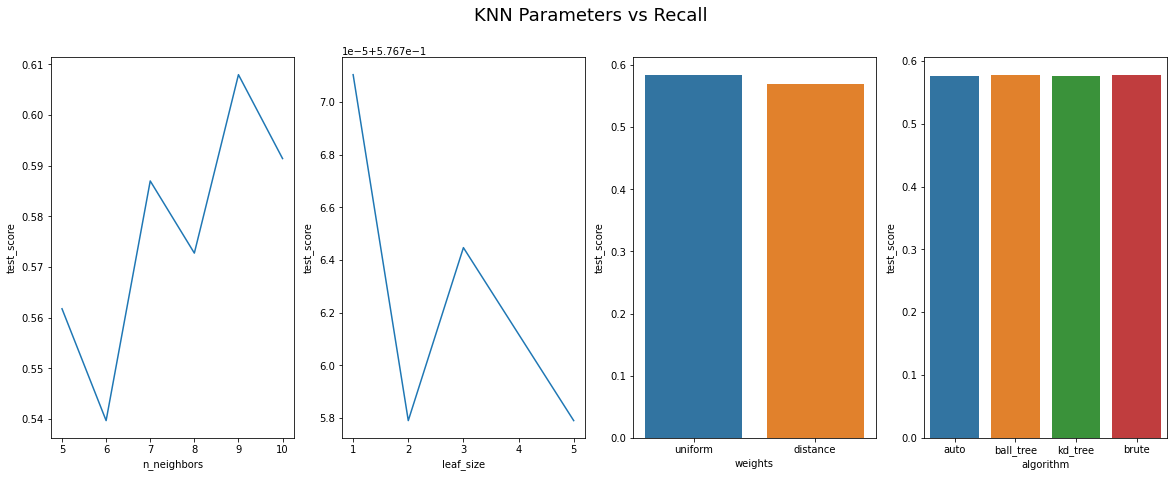

In [164]:
fig, ax = plt.subplots(1,4,figsize=(20,7))
plt.suptitle("KNN Parameters vs Recall", size=18)

sns.lineplot(data=n_neighbors_knn_df, x='n_neighbors', y='test_score', ax=ax[0])
sns.lineplot(data=leaf_size_knn_df, x='leaf_size', y='test_score', ax=ax[1])
sns.barplot(data=weights_knn_df, x='weights', y='test_score', ax=ax[2])
sns.barplot(data=algorithm_knn_df, x='algorithm', y='test_score', ax=ax[3])

plt.show()

#### __F. Comparing Benchmark Model with Tuned Model__

In [171]:
grid_search_knn.best_params_

{'clf__algorithm': 'auto',
 'clf__leaf_size': 1,
 'clf__n_jobs': -1,
 'clf__n_neighbors': 9,
 'clf__weights': 'uniform'}

In [174]:
# Untuk impute dan onehot JOB
mode_onehot_pipeline = Pipeline([
    ('mode_impute_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_onehot', OneHotEncoder(drop='first'))
])

# Untuk impute dan ordinal EDUCATION
mode_ordinal_pipeline = Pipeline([
    ('mode_ordinal_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_ordinal', ce.OrdinalEncoder(cols=['education'], mapping=education_mapping))
])

# Untuk impute dan onehot CONTACT
constant_onehot_pipeline = Pipeline([
    ('constant_impute_cat', SimpleImputer(missing_values='unknown', strategy='constant', fill_value='never')),
    ('constant_onehot', OneHotEncoder(drop='first'))
])

# Untuk onehot MARITAL, DEFAULT, HOUSING, LOAN
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

# Untuk scaling dan polynomial AGE, CAMPAIGN, PDAYS, PREVIOUS
numerical_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
#     ('poly', PolynomialFeatures(3, include_bias=False))
])

transformer_fe = ColumnTransformer([
    ('mode_onehot_pipe', mode_onehot_pipeline, ['job']),
    ('mode_ordinal_pipe', mode_ordinal_pipeline, ['education']),
    ('constant_onehot_pipe', constant_onehot_pipeline, ['contact']),
    ('onehot_pipe', onehot_pipeline, ['marital', 'default', 'housing', 'loan']),
    ('numerical_pipe', numerical_pipeline, ['age','campaign','pdays','previous'])
], remainder='passthrough')

# model initializing
rfc = RandomForestClassifier(random_state=8)
smote = SMOTE(random_state=8)
rfe = RFE(rfc, n_features_to_select = 10, step=1)
knn = KNeighborsClassifier(algorithm='auto',
                             leaf_size= 1,
                             n_jobs= -1,
                             n_neighbors= 9,
                             weights= 'uniform')

knn_tuned_pipeline = Pipeline([
    ('transformer', transformer_fe),
    ('resample', smote),
    ('selection', rfe),
    ('clf', knn)
])

In [175]:
model_tuned_knn = knn_tuned_pipeline.fit(X_train_val, y_train_val)
y_pred_tuned_knn = model_tuned_knn.predict(X_test)

D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [177]:
print(classification_report(y_test, y_pred_tuned_knn))

              precision    recall  f1-score   support

           0       0.94      0.73      0.82      7985
           1       0.24      0.64      0.35      1058

    accuracy                           0.72      9043
   macro avg       0.59      0.69      0.58      9043
weighted avg       0.86      0.72      0.77      9043



__Increasing value of recall from 0.60 to 0.64__

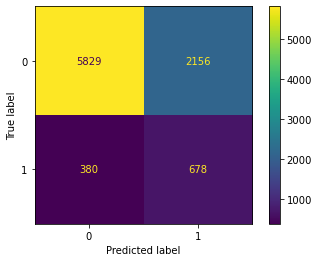

In [178]:
plot_confusion_matrix(knn_tuned_pipeline,
                     X_test,
                     y_test)

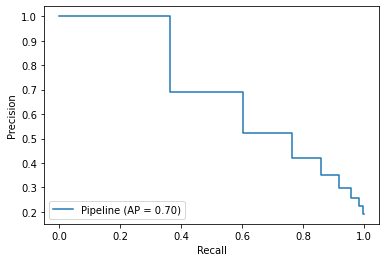

In [176]:
plot_precision_recall_curve(model_tuned_knn, X_train_val, y_train_val)

__Way higher PR AUC for tuned model.__

### __Logistic Regression__

In [31]:
# Untuk impute dan onehot JOB
mode_onehot_pipeline = Pipeline([
    ('mode_impute_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_onehot', OneHotEncoder(drop='first'))
])

# Untuk impute dan ordinal EDUCATION
mode_ordinal_pipeline = Pipeline([
    ('mode_ordinal_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_ordinal', ce.OrdinalEncoder(cols=['education'], mapping=education_mapping))
])

# Untuk impute dan onehot CONTACT
constant_onehot_pipeline = Pipeline([
    ('constant_impute_cat', SimpleImputer(missing_values='unknown', strategy='constant', fill_value='never')),
    ('constant_onehot', OneHotEncoder(drop='first'))
])

# Untuk onehot MARITAL, DEFAULT, HOUSING, LOAN
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

# Untuk scaling dan polynomial AGE, CAMPAIGN, PDAYS, PREVIOUS
numerical_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
#     ('poly', PolynomialFeatures(3, include_bias=False))
])

transformer_fe = ColumnTransformer([
    ('mode_onehot_pipe', mode_onehot_pipeline, ['job']),
    ('mode_ordinal_pipe', mode_ordinal_pipeline, ['education']),
    ('constant_onehot_pipe', constant_onehot_pipeline, ['contact']),
    ('onehot_pipe', onehot_pipeline, ['marital', 'default', 'housing', 'loan']),
    ('numerical_pipe', numerical_pipeline, ['age','campaign','pdays','previous'])
], remainder='passthrough')

# model initializing
rfc = RandomForestClassifier(random_state=8)
smote = SMOTE(random_state=8)
rfe = RFE(rfc, n_features_to_select = 10, step=1)
logreg = LogisticRegression(solver='liblinear', random_state=8)

logreg_pipeline = Pipeline([
    ('transformer', transformer_fe),
    ('resample', smote),
    ('selection', rfe),
    ('clf', logreg)
])

In [32]:
model_default_logreg = logreg_pipeline.fit(X_train, y_train)
y_pred_default_logreg = model_default_logreg.predict(X_val)

D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [33]:
print(classification_report(y_val, y_pred_default_logreg))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87      7984
           1       0.34      0.78      0.47      1058

    accuracy                           0.80      9042
   macro avg       0.65      0.79      0.67      9042
weighted avg       0.89      0.80      0.83      9042



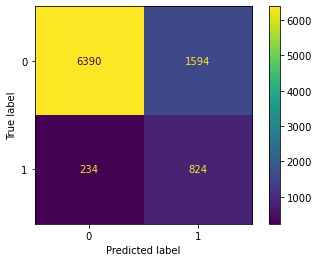

In [34]:
plot_confusion_matrix(logreg_pipeline,
                     X_val,
                     y_val)

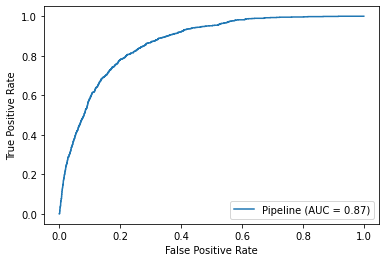

In [35]:
plot_roc_curve(model_default_logreg, X_val, y_val)

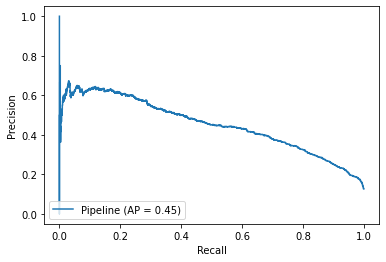

In [36]:
plot_precision_recall_curve(model_default_logreg, X_val, y_val)

In [63]:
logreg_default_cv = cross_val_score(logreg_pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='recall')

In [70]:
logreg_default_cv

array([0.76692913, 0.7681388 , 0.76971609, 0.79527559, 0.76850394])

In [40]:
hyperparam_space_logreg = {
     'clf__C':[1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], # benck mark 1 C = 1 bench mark 2 C = 0.05
    'clf__max_iter':[100, 200, 300, 400, 500, 1000]# bench mark max_iter = 100
}

In [74]:
grid_search_logreg = GridSearchCV(
    logreg_pipeline,
    param_grid = hyperparam_space_logreg,
    cv = 5,
    scoring='recall',
    n_jobs=-1,
    verbose = 1
)

In [75]:
grid_search_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 77.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 194.1min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 199.2min finished
D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('mode_onehot_pipe',
                                                                         Pipeline(steps=[('mode_impute_cat',
                                                                                          SimpleImputer(missing_values='unknown',
                                                                                                        strategy='most_frequent')),
                                                                                         ('mode_onehot',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['job']),
                                                                     

In [78]:
print('best score', grid_search_logreg.best_score_)
print('best params', grid_search_logreg.best_params_)

best score 0.776864800417298
best params {'clf__C': 0.01, 'clf__max_iter': 100}


In [90]:
cv_result_logreg = pd.DataFrame(grid_search_logreg.cv_results_)
cv_result_logreg.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,195.221207,3.036595,0.104940,0.013963,1000,100,"{'clf__C': 1000, 'clf__max_iter': 100}",0.765354,0.768139,0.769716,0.784252,0.768504,0.771193,0.006684,61
1,195.797074,5.615199,0.137122,0.092856,1000,200,"{'clf__C': 1000, 'clf__max_iter': 200}",0.765354,0.768139,0.769716,0.784252,0.768504,0.771193,0.006684,61
2,202.529591,5.010537,0.090549,0.003554,1000,300,"{'clf__C': 1000, 'clf__max_iter': 300}",0.765354,0.768139,0.769716,0.784252,0.768504,0.771193,0.006684,61
3,205.312786,4.551839,0.093947,0.005400,1000,400,"{'clf__C': 1000, 'clf__max_iter': 400}",0.765354,0.768139,0.769716,0.784252,0.768504,0.771193,0.006684,61
4,202.635929,4.146095,0.088749,0.001469,1000,500,"{'clf__C': 1000, 'clf__max_iter': 500}",0.765354,0.768139,0.769716,0.784252,0.768504,0.771193,0.006684,61


In [103]:
cv_result_logreg['C'] = list(map(lambda x: x['clf__C'], cv_result_logreg.params.values))
cv_result_logreg['max_iter'] = list(map(lambda x: x['clf__max_iter'], cv_result_logreg.params.values))
cv_result_logreg.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,C,max_iter
0,195.221207,3.036595,0.104940,0.013963,1000,100,"{'clf__C': 1000, 'clf__max_iter': 100}",0.765354,0.768139,0.769716,0.784252,0.768504,0.771193,0.006684,61,1000.0,100
1,195.797074,5.615199,0.137122,0.092856,1000,200,"{'clf__C': 1000, 'clf__max_iter': 200}",0.765354,0.768139,0.769716,0.784252,0.768504,0.771193,0.006684,61,1000.0,200
2,202.529591,5.010537,0.090549,0.003554,1000,300,"{'clf__C': 1000, 'clf__max_iter': 300}",0.765354,0.768139,0.769716,0.784252,0.768504,0.771193,0.006684,61,1000.0,300
3,205.312786,4.551839,0.093947,0.005400,1000,400,"{'clf__C': 1000, 'clf__max_iter': 400}",0.765354,0.768139,0.769716,0.784252,0.768504,0.771193,0.006684,61,1000.0,400
4,202.635929,4.146095,0.088749,0.001469,1000,500,"{'clf__C': 1000, 'clf__max_iter': 500}",0.765354,0.768139,0.769716,0.784252,0.768504,0.771193,0.006684,61,1000.0,500


In [111]:
mts_list_c = []

for elm in cv_result_logreg['C'].unique():
    mean_elm = cv_result_logreg[cv_result_logreg['C']==elm]['mean_test_score'].mean()
    mts_list_c.append(mean_elm)

In [112]:
c_logreg_df = pd.DataFrame({'C':cv_result_logreg['C'].unique(),
                           'test_score':mts_list_c})

In [114]:
mts_list_max_iter = []

for elm in cv_result_logreg['max_iter'].unique():
    mean_elm = cv_result_logreg[cv_result_logreg['max_iter']==elm]['mean_test_score'].mean()
    mts_list_max_iter.append(mean_elm)

In [115]:
max_iter_logreg_df = pd.DataFrame({'max_iter':cv_result_logreg['max_iter'].unique(),
                           'test_score':mts_list_max_iter})

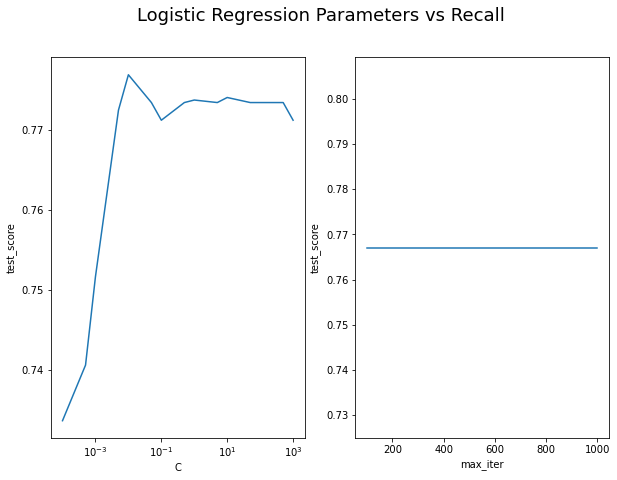

In [180]:
fig, ax = plt.subplots(1,2,figsize=(10,7))
plt.suptitle("Logistic Regression Parameters vs Recall", size=18)

sns.lineplot(data=c_logreg_df, x='C', y='test_score', ax=ax[0])
ax[0].set_xscale('log')

sns.lineplot(data=max_iter_logreg_df, x='max_iter', y='test_score', ax=ax[1])
plt.show()

#### __Comparing Benchmark and Tuned Model__

In [181]:
grid_search_logreg.best_params_

{'clf__C': 0.01, 'clf__max_iter': 100}

In [182]:
# Untuk impute dan onehot JOB
mode_onehot_pipeline = Pipeline([
    ('mode_impute_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_onehot', OneHotEncoder(drop='first'))
])

# Untuk impute dan ordinal EDUCATION
mode_ordinal_pipeline = Pipeline([
    ('mode_ordinal_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_ordinal', ce.OrdinalEncoder(cols=['education'], mapping=education_mapping))
])

# Untuk impute dan onehot CONTACT
constant_onehot_pipeline = Pipeline([
    ('constant_impute_cat', SimpleImputer(missing_values='unknown', strategy='constant', fill_value='never')),
    ('constant_onehot', OneHotEncoder(drop='first'))
])

# Untuk onehot MARITAL, DEFAULT, HOUSING, LOAN
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

# Untuk scaling dan polynomial AGE, CAMPAIGN, PDAYS, PREVIOUS
numerical_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
#     ('poly', PolynomialFeatures(3, include_bias=False))
])

transformer_fe = ColumnTransformer([
    ('mode_onehot_pipe', mode_onehot_pipeline, ['job']),
    ('mode_ordinal_pipe', mode_ordinal_pipeline, ['education']),
    ('constant_onehot_pipe', constant_onehot_pipeline, ['contact']),
    ('onehot_pipe', onehot_pipeline, ['marital', 'default', 'housing', 'loan']),
    ('numerical_pipe', numerical_pipeline, ['age','campaign','pdays','previous'])
], remainder='passthrough')

# model initializing
rfc = RandomForestClassifier(random_state=8)
smote = SMOTE(random_state=8)
rfe = RFE(rfc, n_features_to_select = 10, step=1)
logreg = LogisticRegression(C= 0.01,
                            max_iter= 100,
                            solver='liblinear',
                            random_state=8)

logreg_tuned_pipeline = Pipeline([
    ('transformer', transformer_fe),
    ('resample', smote),
    ('selection', rfe),
    ('clf', logreg)
])

In [183]:
model_tuned_logreg = logreg_tuned_pipeline.fit(X_train_val, y_train_val)
y_pred_tuned_logreg = model_default_logreg.predict(X_test)

D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [185]:
print(classification_report(y_test, y_pred_tuned_logreg))

              precision    recall  f1-score   support

           0       0.97      0.80      0.87      7985
           1       0.34      0.80      0.48      1058

    accuracy                           0.80      9043
   macro avg       0.65      0.80      0.68      9043
weighted avg       0.89      0.80      0.83      9043



__Increase value of recall from 0.78 to 0.80.__

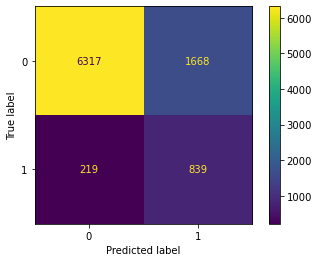

In [186]:
plot_confusion_matrix(logreg_tuned_pipeline,
                     X_test,
                     y_test)

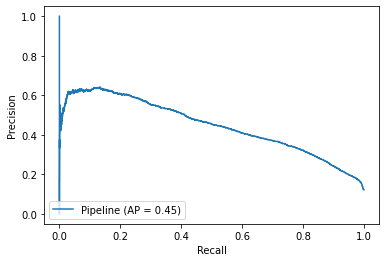

In [187]:
plot_precision_recall_curve(model_tuned_logreg, X_train_val, y_train_val)

### __SVM__

In [81]:
# Untuk impute dan onehot JOB
mode_onehot_pipeline = Pipeline([
    ('mode_impute_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_onehot', OneHotEncoder(drop='first'))
])

# Untuk impute dan ordinal EDUCATION
mode_ordinal_pipeline = Pipeline([
    ('mode_ordinal_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_ordinal', ce.OrdinalEncoder(cols=['education'], mapping=education_mapping))
])

# Untuk impute dan onehot CONTACT
constant_onehot_pipeline = Pipeline([
    ('constant_impute_cat', SimpleImputer(missing_values='unknown', strategy='constant', fill_value='never')),
    ('constant_onehot', OneHotEncoder(drop='first'))
])

# Untuk onehot MARITAL, DEFAULT, HOUSING, LOAN
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

# Untuk scaling dan polynomial AGE, CAMPAIGN, PDAYS, PREVIOUS
numerical_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
#     ('poly', PolynomialFeatures(3, include_bias=False))
])

transformer_fe = ColumnTransformer([
    ('mode_onehot_pipe', mode_onehot_pipeline, ['job']),
    ('mode_ordinal_pipe', mode_ordinal_pipeline, ['education']),
    ('constant_onehot_pipe', constant_onehot_pipeline, ['contact']),
    ('onehot_pipe', onehot_pipeline, ['marital', 'default', 'housing', 'loan']),
    ('numerical_pipe', numerical_pipeline, ['age','campaign','pdays','previous'])
], remainder='passthrough')

# model initializing
rfc = RandomForestClassifier(random_state=8)
smote = SMOTE(random_state=8)
rfe = RFE(rfc, n_features_to_select = 10, step=1)
svc = SVC(random_state=8, probability=True, C=10)

svm_pipeline = Pipeline([
    ('transformer', transformer_fe),
    ('resample', smote),
    ('selection', rfe),
    ('clf', svc)
])

In [43]:
model_default_svm = svm_pipeline.fit(X_train, y_train)
y_pred_default_svm = model_default_svm.predict(X_val)

D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [44]:
print(classification_report(y_val, y_pred_default_svm))

              precision    recall  f1-score   support

           0       0.95      0.78      0.85      7984
           1       0.29      0.68      0.40      1058

    accuracy                           0.76      9042
   macro avg       0.62      0.73      0.63      9042
weighted avg       0.87      0.76      0.80      9042



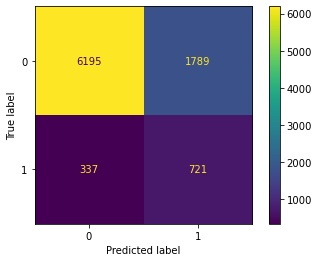

In [45]:
plot_confusion_matrix(svm_pipeline,
                     X_val,
                     y_val)

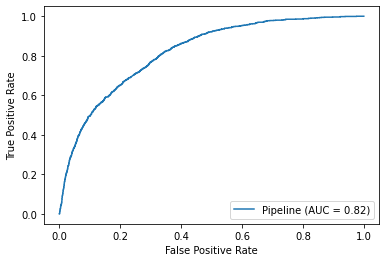

In [46]:
plot_roc_curve(model_default_svm, X_val, y_val)

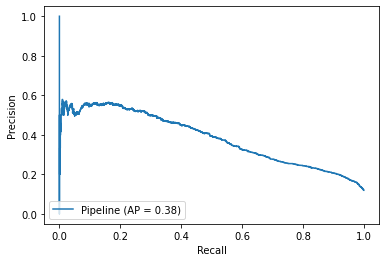

In [47]:
plot_precision_recall_curve(model_default_svm, X_val, y_val)

In [66]:
svm_default_cv = cross_val_score(svm_pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='recall')

In [68]:
svm_default_cv

array([0.65826772, 0.68454259, 0.64826498, 0.70393701, 0.6976378 ])

In [188]:
param_grid_svm = {'clf__C': [0.1,1, 10, 100], 
                  'clf__gamma': [1,0.1,0.01,0.001],
                  'clf__kernel': ['rbf'], 
                  'clf__degree': [1,2,3]}

In [189]:
grid_search_svm = GridSearchCV(
    svm_pipeline,
    param_grid = param_grid_svm,
    cv = 2,
    scoring='recall',
    n_jobs=-1,
    verbose = 1
)

In [ ]:
grid_search_svm.fit(X_train, y_train)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
cv_result_svm = pd.DataFrame(grid_search_svm.cv_results_)
cv_result_svm.head()

In [ ]:
cv_result_svm[cv_result_svm['rank_test_score']==1]

### __Gradient Boosting__

In [48]:
# Untuk impute dan onehot JOB
mode_onehot_pipeline = Pipeline([
    ('mode_impute_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_onehot', OneHotEncoder(drop='first'))
])

# Untuk impute dan ordinal EDUCATION
mode_ordinal_pipeline = Pipeline([
    ('mode_ordinal_cat', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('mode_ordinal', ce.OrdinalEncoder(cols=['education'], mapping=education_mapping))
])

# Untuk impute dan onehot CONTACT
constant_onehot_pipeline = Pipeline([
    ('constant_impute_cat', SimpleImputer(missing_values='unknown', strategy='constant', fill_value='never')),
    ('constant_onehot', OneHotEncoder(drop='first'))
])

# Untuk onehot MARITAL, DEFAULT, HOUSING, LOAN
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

# Untuk scaling dan polynomial AGE, CAMPAIGN, PDAYS, PREVIOUS
# numerical_pipeline = Pipeline([
#     ('minmax_scaler', MinMaxScaler())
#     ('poly', PolynomialFeatures(3, include_bias=False))
# ])

transformer_fe = ColumnTransformer([
    ('mode_onehot_pipe', mode_onehot_pipeline, ['job']),
    ('mode_ordinal_pipe', mode_ordinal_pipeline, ['education']),
    ('constant_onehot_pipe', constant_onehot_pipeline, ['contact']),
    ('onehot_pipe', onehot_pipeline, ['marital', 'default', 'housing', 'loan'])
#     ('numerical_pipe', numerical_pipeline, ['age','campaign','pdays','previous'])
], remainder='passthrough')

# model initializing
rfc = RandomForestClassifier(random_state=8)
smote = SMOTE(random_state=8)
rfe = RFE(rfc, n_features_to_select = 10, step=1)
gboost = GradientBoostingClassifier(random_state=8)

gb_pipeline = Pipeline([
    ('transformer', transformer_fe),
    ('resample', smote),
    ('selection', rfe),
    ('clf', gboost)
])

In [49]:
model_default_gb = gb_pipeline.fit(X_train, y_train)
y_pred_default_gb = model_default_gb.predict(X_val)

D:\Install\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [50]:
print(classification_report(y_val, y_pred_default_gb))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      7984
           1       0.54      0.49      0.51      1058

    accuracy                           0.89      9042
   macro avg       0.74      0.72      0.73      9042
weighted avg       0.89      0.89      0.89      9042



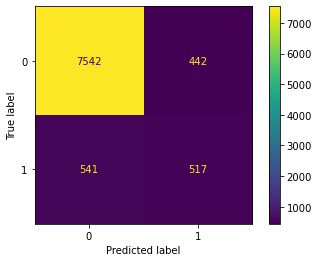

In [51]:
plot_confusion_matrix(gb_pipeline,
                     X_val,
                     y_val)

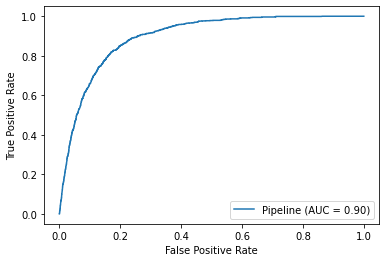

In [52]:
plot_roc_curve(model_default_gb, X_val, y_val)

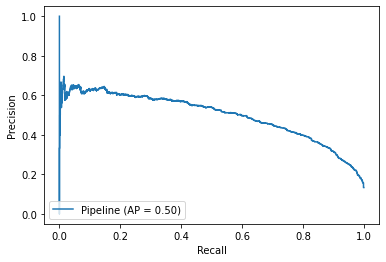

In [53]:
plot_precision_recall_curve(model_default_gb, X_val, y_val)

In [67]:
gb_default_cv = cross_val_score(gb_pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='recall')

In [69]:
gb_default_cv

array([0.48031496, 0.47949527, 0.51419558, 0.50708661, 0.48503937])

In [ ]:
param_grid_gb = {
    "clf__n_estimators":[5,50,250,500],
    "clf__max_depth":[1,3,5,7,9],
    "clf__learning_rate":[0.01,0.1,1,10,100]
}

In [ ]:
grid_search_gb = GridSearchCV(
    gb_pipeline,
    param_grid = param_grid_gb,
    cv = 5,
    scoring='recall',
    n_jobs=-1,
    verbose = 1
)

In [ ]:
grid_search_gb.fit(X_train, y_train)

In [ ]:
cv_result_gb = pd.DataFrame(grid_search_gb.cv_results_)
cv_result_gb.head()

In [ ]:
cv_result_gb[cv_result_gb['rank_test_score']==1]